In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = np.array([[1, 6.2], [2, 9.5], [3,12.3], [4, 13.9], [5, 14.6], [6, 13.5], [7, 13.3], [8, 12.7], [9, 12.4], [10, 11.9]], dtype=np.float64)

Function for cubic splines:

In [35]:
def cubicspline(data):
    """
    Creates a set of cubic splines from data
    Returns a set of functions, which allows evaluation of splines
    """
    n = data.shape[0]

    dx = data[1:, 0] -  data[:-1, 0]
    dy = data[1:, 1] -  data[:-1, 1]

    #Creating the diagonal columns of the SDD matrix we want to solve
    diagonal = np.ones(n)
    diagonal[1:n-1] = 2*dx[:n-2] + 2*dx[1:]
    diagonalu = np.zeros(n - 1)
    diagonalu[1:] = dx[1:]
    diagonall = np.zeros(n - 1)
    diagonall[:n - 2] = dx[:n-2]

    #Creating matrices with diagonal columns of the SDD matrix we want to solve
    U = np.diag(diagonalu, 1) 
    A = np.diag(diagonal)
    L = np.diag(diagonall, -1)

    #Adding up the matricies to create the final SDD matrix which we can solve to find the c coefficients
    A = A + U + L

    #Creating the constants vector which is on the rhs of the equation Ac = b
    bconstants = np.zeros(n)
    bconstants[1:n-1] = 3*(dy[1:]/dx[1:] - dy[:n-2]/dx[:n-2])

    #Solving for c, b, and d coefficients
    c = np.linalg.solve(A, bconstants)
    d = (c[1:] - c[:n-1])/(3*dx)
    b = dy/dx - dx/3*(2*c[:n-1] + c[1:])

    spline_func = [0]*(n-1)
    for i in range(n - 1):
        spline_func[i] = lambda x, i=i: data[i,1] + b[i]*(x - data[i,0]) + c[i]*(x - data[i,0])**2 + d[i]*(x - data[i,0])**3
    #spline_func is a list which stores the ith cubic polynomial at index i-1, calling spline_func[i - 1](x) evaluates the ith polynomial at x 
    
    return spline_func

Function for polynomial interpolation with vandermonde matrix (has same unique solution as lagrange):

In [36]:
def interpolation(data):
    ''' 
    Polynomial interpolation using Vandermonde matrix
    Takes data in the form of x in the first column and y in the second
    Returns the coefficients for the interpolating polynomial
    '''
    n = data.shape[0]
    A = np.zeros((n,n))
    A[:, 0] = 1
    for i in range(1, n):
        A[:, i] = data[:,0]**i
    c = np.linalg.solve(A, data[:,1])
    return c


In [37]:
def polynomialsolve(x, c):
    """
    Takes in input data as x, and a vector of coefficients c and evaluated the polynomial determined by these coefficients
    """
    f = 0
    for i in range(np.size(c)):
        f = f + c[i]*x**i
    return f

Trigonometric Interpolation:

In [38]:
def dftinterp(inter, x, n, p):
    c, d = inter
    t = c + (d - c) * np.linspace(0, n - 1, n) / n
    tp = c + (d - c) * np.linspace(0, p - 1, p) / p
    
    y = np.fft.fft(x)
    yp = np.zeros(p, dtype=complex)
    yp[:n//2 + 1] = y[:n//2 + 1]
    yp[p - n//2 + 1:] = y[n//2 + 1:]
    
    xp = np.real(np.fft.ifft(yp)) * (p / n)
    
    #plt.plot(t, x, 'o', tp, xp)
    #plt.show()
    return((tp, xp))

Testing Vandermonde matrix and Cubic Spline function:

In [39]:
data = np.array([[1, 6.2], [2, 9.5], [3,12.3], [4, 13.9], [5, 14.6], [6, 13.5], [7, 13.3], [8, 12.7], [9, 12.4], [10, 11.9]], dtype=np.float64)
c = interpolation(data)
print(polynomialsolve(np.arange(1,2.1, 0.1), c))
spline = cubicspline(data)
print(spline[0](np.arange(1,2.1, 0.1)))

[6.2        4.94350553 4.4774259  4.56420533 5.01691864 5.69127502
 6.47854775 7.29935454 8.09821739 8.83883446 9.5       ]
[6.2        6.53538841 6.87045026 7.20485896 7.53828795 7.87041065
 8.20090051 8.52943094 8.85567538 9.17930726 9.5       ]


Graphing both polynomial interpolation by Vandermonde matrix and cubic splines:


In [40]:
xint = np.arange(1,10.1,0.1)
c = interpolation(data)
p = polynomialsolve(xint, c)

In [41]:
c = cubicspline(data)
points = 10
m = data[:,0].size
p2 = np.zeros(points*(m - 1))
for i in range(m - 1):
    space = (data[i + 1,0] - data[i,0])/points
    x = np.arange(data[i,0],data[i + 1,0], space)
    if i == 0:
        xx = x
    else:
        xx = np.append(xx, x)
    p2[(points*i):(points*i+points)] = c[i](x)

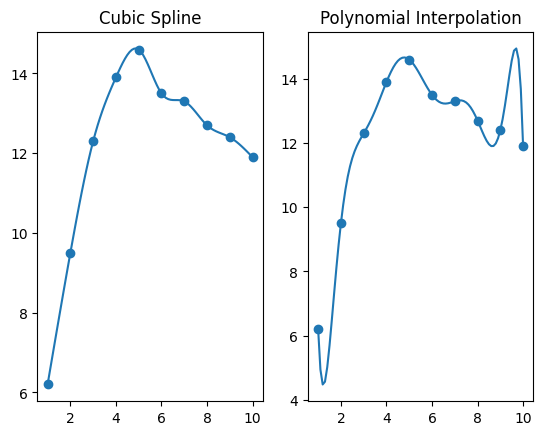

In [42]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(xx, p2, label = "Cubic Spline")
ax[1].plot(xint, p, label = "Polynomial Interpolation")
ax[0].scatter(data[:,0],data[:,1])
ax[1].scatter(data[:,0],data[:,1])
ax[0].set_title("Cubic Spline") 
ax[1].set_title("Polynomial Interpolation")
plt.show()

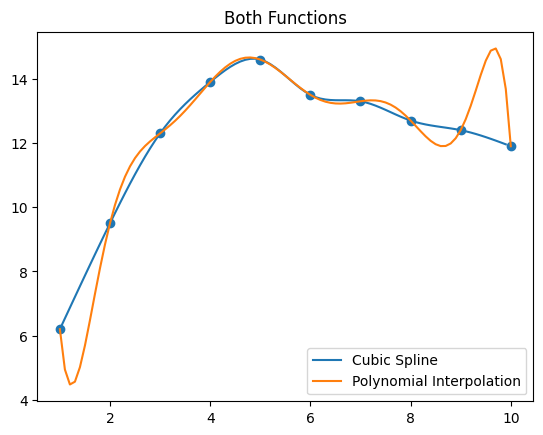

In [43]:
fig, ax = plt.subplots()
ax.scatter(data[:,0],data[:,1])
ax.plot(xx, p2, label = "Cubic Spline")
ax.plot(xint, p, label = "Polynomial Interpolation")
ax.legend()
ax.set_title("Both Functions") 
plt.show()

In the above example, the points were not generated with a function, so we don't compute an error term. 

Runge Phenomenon Example:

In [44]:
xdata = np.arange(-1, 1, 0.1)
runge = 1/(1 + 25*xdata*xdata)
rungedata = np.column_stack((xdata, runge))

In [45]:
cspline = cubicspline(rungedata)
points = 10
m = np.size(xdata)
p2 = np.zeros(points*(m - 1))
for i in range(m - 1):
    space = (xdata[i + 1] - xdata[i])/points
    x = np.arange(xdata[i],xdata[i + 1], space)
    if i == 0:
        xgraph = x
    else:
        xgraph = np.append(xgraph, x)
    p2[(points*i):(points*i+points)] = cspline[i](x)

In [46]:
c = interpolation(rungedata)
p = polynomialsolve(xgraph, c)

In [47]:
xtrig, trig = dftinterp((-1, 1), runge, 20, 200)

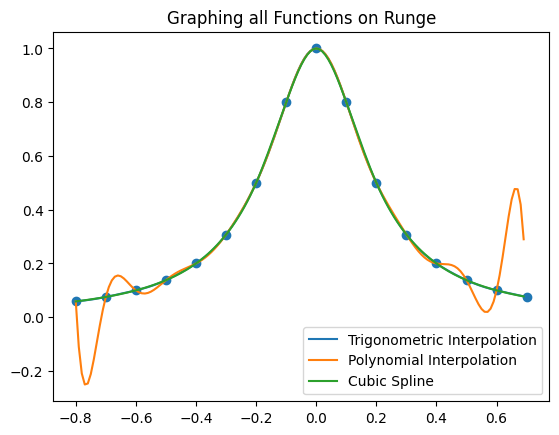

In [48]:
fig, ax = plt.subplots()
ax.scatter(rungedata[2:-2,0],rungedata[2:-2,1])
ax.plot(xgraph[20:-20], trig[20:-30], label = "Trigonometric Interpolation")
ax.plot(xgraph[20:-20], p[20:-20], label = "Polynomial Interpolation")
ax.plot(xgraph[20:-20], p2[20:-20], label = "Cubic Spline")
ax.legend()
ax.set_title("Graphing all Functions on Runge") 
plt.show()

Graph of Trigonometric Interpolation:

Error Computation by RMSE:

In [49]:
real = 1/(1 + 25*xgraph[20:-20]*xgraph[20:-20])
rmsespline = ((np.sum(real - p2[20:-20]))**2)/np.size(xgraph[20:-20])
rmsepolyint = ((np.sum(real - p[20:-20]))**2)/np.size(xgraph[20:-20])
rmsetrig = ((np.sum(real - trig[20:-30]))**2)/np.size(xgraph[20:-20])


In [50]:
print(f"RMSE of Cubic Spline: {rmsespline}")
print(f"RMSE of Polynomial Interpolation: {rmsepolyint}")
print(f"RMSE of Trig Interpolation: {rmsetrig}")

RMSE of Cubic Spline: 2.357477066595482e-09
RMSE of Polynomial Interpolation: 0.001055085220894519
RMSE of Trig Interpolation: 1.8021980699693492e-09


Error Computation by max norm of error:

In [51]:
maxerrorspline = np.max(abs(real - p2[20:-20]))
maxerrorpolyint = np.max(abs(real - p[20:-20]))
maxerrortrig = np.max(abs(real - trig[20:-30]))

In [52]:
print(f"Max norm of Error of Cubic Spline: {maxerrorspline}")
print(f"Max norm of Error of Polynomial Interpolation: {maxerrorpolyint}")
print(f"Max norm of Error of Trig Interpolation: {maxerrortrig}")

Max norm of Error of Cubic Spline: 0.003168938900935725
Max norm of Error of Polynomial Interpolation: 0.39452219759765966
Max norm of Error of Trig Interpolation: 0.0017455429222741348


Error Computation by Integral of Absolute Value of Difference:

In [53]:
#Error of cubic spline
e1 = np.trapz(np.abs(p2[20:-20] - real) , xgraph[20:-20])
print(e1)

#Error of polynomial interpolition
e2 = np.trapz(np.abs(p[20:-20] - real) , xgraph[20:-20])
print(e2)

e3 = np.trapz(np.abs(trig[20:-30] - real) , xgraph[20:-20])
print(e3)

0.0008016675976101903
0.0578898966676758
0.0011951840113397344


Table of Error for Runge Phenomenon Example, $\frac{1}{1 + 25x^2}$

In [54]:
dict = {"RMSE": [rmsespline, rmsepolyint, rmsetrig], "Max Norm of Error": [maxerrorspline, maxerrorpolyint, maxerrortrig], "Numeric Integral": [e1, e2, e3]}
table = pd.DataFrame(dict, index = ["Cubic Spline", "Polynomial Interpolation", "Trigonometric Interpolation"])
table

,RMSE,Max Norm of Error,Numeric Integral
Cubic Spline,2.357477e-09,0.003169,0.000802
Polynomial Interpolation,1.055085e-03,0.394522,0.057890
Trigonometric Interpolation,1.802198e-09,0.001746,0.001195


Next, we use our methods on the function $f(x) = sin(x^2) + 1/2x$

In [55]:
xdata = np.arange(-5, 5, 0.1)
sin = np.sin(xdata**2) + 1/2*xdata
sindata = np.column_stack((xdata, sin))
xdata.size

100

In [56]:
cspline = cubicspline(sindata)
points = 10
m = np.size(xdata)
p2 = np.zeros(points*(m - 1))
for i in range(m - 1):
    space = (xdata[i + 1] - xdata[i])/points
    x = np.arange(xdata[i],xdata[i + 1], space)
    if i == 0:
        xgraph = x
    else:
        xgraph = np.append(xgraph, x)
    p2[(points*i):(points*i+points)] = cspline[i](x)

In [57]:
c = interpolation(sindata)
p = polynomialsolve(xgraph, c)

In [58]:
xtrig, trig = dftinterp((-5, 5), sin, 100, 1000)

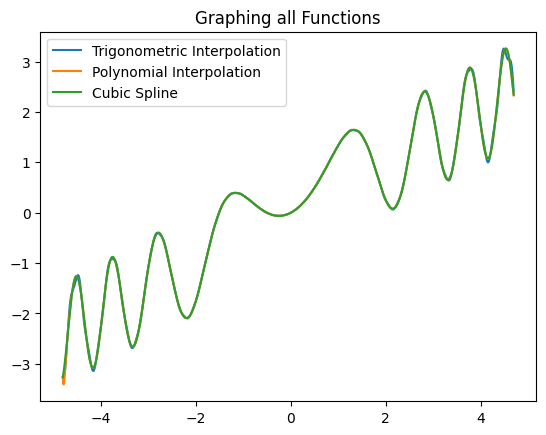

In [59]:
fig, ax = plt.subplots()
ax.plot(xgraph[20:-20], trig[20:-30], label = "Trigonometric Interpolation")
ax.plot(xgraph[20:-20], p[20:-20], label = "Polynomial Interpolation")
ax.plot(xgraph[20:-20], p2[20:-20], label = "Cubic Spline")
ax.legend()
ax.set_title("Graphing all Functions") 
plt.show()

Error Computation by RMSE:

In [60]:
real = np.sin(xgraph[20:-20]**2) + 1/2*xgraph[20:-20]
rmsespline = ((np.sum(real - p2[20:-20]))**2)/np.size(xgraph[20:-20])
rmsepolyint = ((np.sum(real - p[20:-20]))**2)/np.size(xgraph[20:-20])
rmsetrig = ((np.sum(real - trig[20:-30]))**2)/np.size(xgraph[20:-20])


In [61]:
print(f"RMSE of Cubic Spline: {rmsespline}")
print(f"RMSE of Polynomial Interpolation: {rmsepolyint}")
print(f"RMSE of Trig Interpolation: {rmsetrig}")

RMSE of Cubic Spline: 4.168908210520648e-08
RMSE of Polynomial Interpolation: 0.002212156333061692
RMSE of Trig Interpolation: 4.830535696308797e-06


Error Computation by max norm of error:

In [62]:
maxerrorspline = np.max(abs(real - p2[20:-20]))
maxerrorpolyint = np.max(abs(real - p[20:-20]))
maxerrortrig = np.max(abs(real - trig[20:-30]))

In [63]:
print(f"Max norm of Error of Cubic Spline: {maxerrorspline}")
print(f"Max norm of Error of Polynomial Interpolation: {maxerrorpolyint}")
print(f"Max norm of Error of Trig Interpolation: {maxerrortrig}")

Max norm of Error of Cubic Spline: 0.0030300334338466683
Max norm of Error of Polynomial Interpolation: 0.2804963376225209
Max norm of Error of Trig Interpolation: 0.21107209968525487


Error Computation by Integral of Absolute Value of Difference:

In [64]:
#Error of cubic spline
e1 = np.trapz(np.abs(p2[20:-20] - real) , xgraph[20:-20])
print(e1)

#Error of polynomial interpolition
e2 = np.trapz(np.abs(p[20:-20] - real) , xgraph[20:-20])
print(e2)

e3 = np.trapz(np.abs(trig[20:-30] - real) , xgraph[20:-20])
print(e3)

0.0018660337886602558
0.01848064913219598
0.1985787652067703


Table of Error for $f(x) = sin(x^2) + 1/2x$

In [65]:
dict = {"RMSE": [rmsespline, rmsepolyint, rmsetrig], "Max Norm of Error": [maxerrorspline, maxerrorpolyint, maxerrortrig], "Numeric Integral": [e1, e2, e3]}
table = pd.DataFrame(dict, index = ["Cubic Spline", "Polynomial Interpolation", "Trigonometric Interpolation"])
table

,RMSE,Max Norm of Error,Numeric Integral
Cubic Spline,4.168908e-08,0.003030,0.001866
Polynomial Interpolation,2.212156e-03,0.280496,0.018481
Trigonometric Interpolation,4.830536e-06,0.211072,0.198579


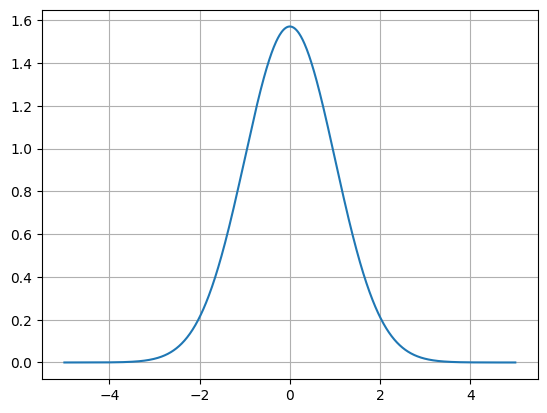

In [66]:
#define normal function
def normal_f(x):
    return 1/2*np.pi*np.exp(-1/2*x**2)

#gererate the graph
x = np.linspace(-5, 5, 1000)
plt.plot(x, normal_f(x))
plt.grid(True)
plt.show()

In [67]:
xdata = np.arange(-5, 5, 0.1)
runge = normal_f(xdata)
rungedata = np.column_stack((xdata, runge))

In [68]:
cspline = cubicspline(rungedata)
points = 10
m = np.size(xdata)
p2 = np.zeros(points*(m - 1))
for i in range(m - 1):
    space = (xdata[i + 1] - xdata[i])/points
    x = np.arange(xdata[i],xdata[i + 1], space)
    if i == 0:
        xgraph = x
    else:
        xgraph = np.append(xgraph, x)
    p2[(points*i):(points*i+points)] = cspline[i](x)

In [69]:
c = interpolation(rungedata)
p = polynomialsolve(xgraph, c)

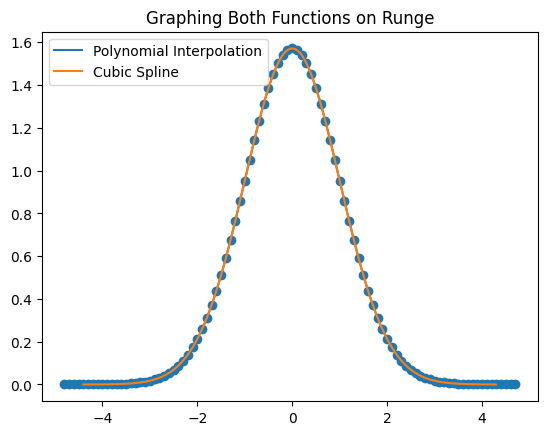

In [70]:
fig, ax = plt.subplots()
ax.scatter(rungedata[2:-2,0],rungedata[2:-2,1])
ax.plot(xgraph[60:-60], p[60:-60], label = "Polynomial Interpolation")
ax.plot(xgraph[60:-60], p2[60:-60], label = "Cubic Spline")
ax.legend()
ax.set_title("Graphing Both Functions on Runge") 
plt.show()

In [71]:
real = normal_f(xgraph[60:-60])
rmsespline = ((np.sum(real - p2[60:-60]))**2)/np.size(xgraph[60:-60])
rmsepolyint = ((np.sum(real - p[60:-60]))**2)/np.size(xgraph[60:-60])


In [72]:
print(f"RMSE of Cubic Spline: {rmsespline}")
print(f"RMSE of Polynomial Interpolation: {rmsepolyint}")


RMSE of Cubic Spline: 6.039644497291035e-17
RMSE of Polynomial Interpolation: 1.7139145807005033e-16


In [73]:
maxerrorspline = np.max(abs(real - p2[60:-60]))
maxerrorpolyint = np.max(abs(real - p[60:-60]))


In [74]:
print(f"Max norm of Error of Cubic Spline: {maxerrorspline}")
print(f"Max norm of Error of Polynomial Interpolation: {maxerrorpolyint}")


Max norm of Error of Cubic Spline: 1.2348201001710635e-06
Max norm of Error of Polynomial Interpolation: 4.700225720744998e-09


In [75]:
#Error of cubic spline
e1 = np.trapz(np.abs(p2[60:-60] - real) , xgraph[60:-60])
print(e1)

#Error of polynomial interpolition
e2 = np.trapz(np.abs(p[60:-60] - real) , xgraph[60:-60])
print(e2)



1.550494792371556e-06
5.419612435182116e-09


In [76]:
dict = {"RMSE": [rmsespline, rmsepolyint], "Max Norm of Error": [maxerrorspline, maxerrorpolyint], "Numeric Integral": [e1, e2]}
table = pd.DataFrame(dict, index = ["Cubic Spline", "Polynomial Interpolation"])
table

,RMSE,Max Norm of Error,Numeric Integral
Cubic Spline,6.039644e-17,1.234820e-06,1.550495e-06
Polynomial Interpolation,1.713915e-16,4.700226e-09,5.419612e-09
